In [1]:
# Import libraries
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import cv2

---
### `detect_leaves` function
The `detect_leaves` function in the code identifies areas in an image that are likely to be leaves based on their size and shape. It applies image processing techniques like blurring, binarization, and contour detection, and returns the locations of these areas as bounding boxes.

In [2]:
def blur_image(input_image, kernel_size):
    """
    Apply a blur to the input image.

    Blurring is used as a preprocessing step in our image processing pipeline. 
    It helps to reduce noise and detail in the image. By doing so, it simplifies 
    the image and makes subsequent processing steps like binarization and contour 
    detection more effective. The level of blurring is controlled by the kernel size: 
    a larger kernel will produce a more blurred image.

    Args:
    input_image (numpy.ndarray): The input image to be blurred.
    kernel_size (tuple): The size of the kernel to be used for blurring. 
                         The kernel is a rectangle of size kernel_size that 
                         moves over the image to average the pixel values.

    Returns:
    numpy.ndarray: The blurred version of the input image.
    """
    return cv2.blur(input_image, kernel_size)



def binarize_and_invert_image(image, bin_threshold, max_value, inv_threshold):
    """
    Binarize and invert the image using specific thresholds.

    This function is a key part of the image processing pipeline for leaf detection. 
    It first binarizes the image, converting it to a binary image where pixels are 
    either black or white based on the provided threshold. This simplifies the image 
    and makes it easier to detect the leaves.

    After binarization, the function converts the image to grayscale. This is done 
    because the inversion function works on single channel images, and the binarization 
    process may leave the image in a multi-channel state.

    Finally, the function inverts the binary image. In the context of leaf detection, 
    this step helps to highlight the leaves (which are now white) against the background 
    (which is now black).

    Args:
    image (numpy.ndarray): The input image to be processed.
    bin_threshold (int): The threshold for binarization. Pixels with a value greater 
                         than this threshold will be set to the max_value.
    max_value (int): The value to be given to pixels that exceed the bin_threshold.
    inv_threshold (int): The threshold for inversion. Pixels with a value greater than 
                         this threshold will be set to 0 (black), and those with a 
                         value less than or equal to this threshold will be set to 
                         max_value (white).

    Returns:
    numpy.ndarray: The processed image, which is a grayscale, binary, inverted version 
                   of the input image.
    """
    _, binarized_image = cv2.threshold(image, bin_threshold, max_value, cv2.THRESH_BINARY)
    grayscale_image = cv2.cvtColor(binarized_image, cv2.COLOR_BGR2GRAY)
    _, inverted_image = cv2.threshold(grayscale_image, inv_threshold, max_value, cv2.THRESH_BINARY_INV)
    
    return inverted_image



def find_and_filter_contours(image, threshold_area, min_width, min_height):
    """
    Find contours in the image and filter them based on area, width, and height.

    Args:
    image (numpy.ndarray): The input image, which should be a binary image where the 
                           leaves are white and the background is black.
    threshold_area (int): The minimum area for a contour to be considered. Contours 
                          with an area less than this will be ignored.
    min_width (int): The minimum width for a contour to be considered. Contours with 
                     a width less than this will be ignored.
    min_height (int): The minimum height for a contour to be considered. Contours with 
                      a height less than this will be ignored.

    Returns:
    numpy.ndarray: An array of bounding boxes for the filtered contours, sorted from 
                   left to right. Each bounding box is represented as a list of four 
                   coordinates [x, y, x+w, y+h].
    """
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    bounding_boxes = []
    for c in contours:
        area = cv2.contourArea(c)
        if area > threshold_area:
            x, y, w, h = cv2.boundingRect(c)
            if w > min_width and h > min_height:
                bounding_boxes.append([x, y, x+w, y+h])
    
    # Sort the bounding boxes from left to right
    bounding_boxes = sorted(bounding_boxes, key=lambda b: b[0])
    
    return np.array(bounding_boxes)



def detect_leaves(input_image):
    """
    Detects and returns bounding boxes around specific areas (leaves) in the input image.
    
    Args:
    input_image (numpy.ndarray): Input image to detect leaves from.
    
    Returns:
    numpy.ndarray: Array containing bounding boxes around leaves.
    """
    blurred_image = blur_image(input_image, BLUR_KERNEL_SIZE)
    processed_image = binarize_and_invert_image(blurred_image, BINARY_THRESHOLD, MAX_BINARY_VALUE, BINARY_INV_THRESHOLD)
    bounding_boxes = find_and_filter_contours(processed_image, THRESHOLD_AREA, MIN_WIDTH, MIN_HEIGHT)
    return bounding_boxes

---
### Example of leaves detection :

In [3]:
# Constants
BLUR_KERNEL_SIZE = (80, 80)

THRESHOLD_AREA = 600000
BINARY_THRESHOLD = 128
MAX_BINARY_VALUE = 255
BINARY_INV_THRESHOLD = 245

MIN_WIDTH = 400
MIN_HEIGHT = 5000

Corrupt JPEG data: 4110 extraneous bytes before marker 0xd5


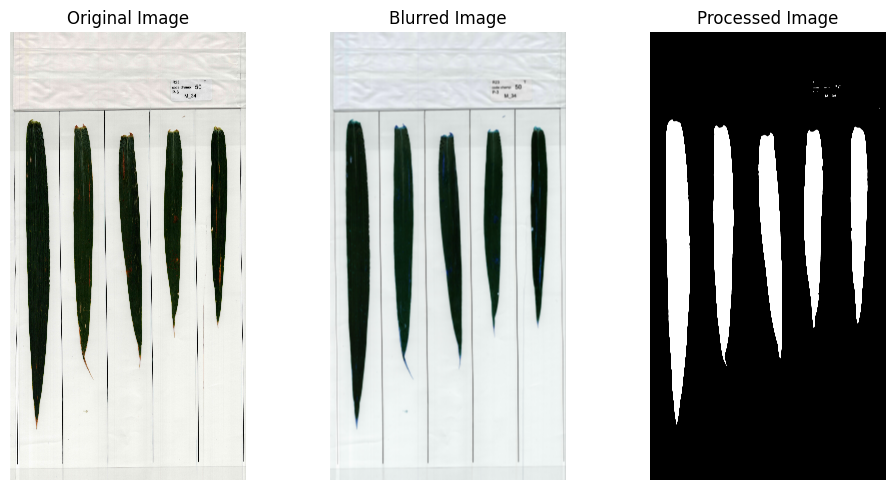

leaves coordinates : 
[[  689  3839  1756 17226]
 [ 2774  4087  3663 14651]
 [ 4749  4420  5784 14320]
 [ 6730  4286  7570 12985]
 [ 8782  4155  9528 12790]]
Time taken to process leaves detection : 0.884 seconds


In [4]:
start_time = time.time()
input_image = cv2.imread('../1.jpg')
blurred_image = blur_image(input_image, BLUR_KERNEL_SIZE)
processed_image = binarize_and_invert_image(blurred_image, BINARY_THRESHOLD, MAX_BINARY_VALUE, BINARY_INV_THRESHOLD)
bounding_boxes = find_and_filter_contours(processed_image, THRESHOLD_AREA, MIN_WIDTH, MIN_HEIGHT)
end_time = time.time()

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(blurred_image, cmap='gray')
plt.title('Blurred Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(processed_image, cmap='gray')
plt.title('Processed Image')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"leaves coordinates : \n{bounding_boxes}")
print(f"Time taken to process leaves detection : {end_time - start_time:.3f} seconds")

---
### `is_image_usable` function
The `is_image_usable` function's goal is to determine whether an image is usable or not based on its dimensions. We have experimentally found that issues during leaf scanning are associated with images that are either too small or too large in dimensions.

In [5]:
# Define the threshold values for image dimensions as constants
MIN_HEIGHT_FILE = 11000 # Minimum acceptable image height in pixels
MAX_HEIGHT_FILE = 22500 # Maximum acceptable image height in pixels

In [6]:
def is_image_usable(image):
    """
    Checks if the image is usable based on its dimensions.
    
    Args:
    image (numpy.ndarray): Input image to check for usability.
    
    Returns:
    bool: True if the image is usable, False otherwise.
    """
    # Get the height of the image
    height = image.shape[0]
    
    # Check if the height is within the acceptable range
    return MIN_HEIGHT_FILE <= height <= MAX_HEIGHT_FILE

In [7]:
print(is_image_usable(input_image))

True


---

In [8]:
# Define constants
IMAGE_EXTENSIONS = ['.jpg', '.png']
NEW_RESULTS_DIR = 'results'
FILE_DIR = 'File'
UNUSABLE_FILE_DIR = 'Unusable_File'


def count_files_in_directory(directory, extensions):
    """
    Count the number of files in a directory that have a certain extension.

    Args:
    directory (str): The path to the directory to search.
    extensions (list): A list of file extensions to count.

    Returns:
    int: The number of files in the directory that have one of the specified extensions.
    """
    # os.path.splitext(filename)[1] gets the file extension of filename
    # .lower() converts the extension to lowercase for case-insensitive comparison
    return sum(os.path.splitext(filename)[1].lower() in extensions for filename in os.listdir(directory))


def create_directory(path):
    """
    Creates a new directory.

    This function uses the os.makedirs() function to create a new directory at the specified path.
    The exist_ok parameter is set to True, which means the function will not raise an error if the directory already exists.

    Args:
    path (str): The path where the new directory should be created.
    """
    os.makedirs(path, exist_ok=True)


def image_processing(entry_path, exit_path):
    """
    Process all image files in a directory: count them, create necessary directories, process each image, and print the results.

    Args:
    entry_path (str): The path to the directory containing the image files to process.
    exit_path (str): The path to the directory where the processed images will be saved.
    """

    # Count the number of image files in the directory
    num_files = count_files_in_directory(entry_path, IMAGE_EXTENSIONS)

    # Create a new directory for the results
    new_results_path = os.path.join(exit_path, NEW_RESULTS_DIR)
    create_directory(new_results_path)

    # Create subdirectories for the processed and unusable images
    file_path = os.path.join(new_results_path, FILE_DIR)
    unusable_file_path = os.path.join(new_results_path, UNUSABLE_FILE_DIR)
    create_directory(file_path)
    create_directory(unusable_file_path)

    # Initialize counters for the total number of files and the number of unusable files
    count_files = 0
    count_unusable_files = 0

    # Process each file in the directory
    for filename in os.listdir(entry_path):
        # Check if the file is an image file
        if os.path.splitext(filename)[1].lower() in IMAGE_EXTENSIONS:

            # Create the full path to the image file
            full_path = os.path.join(entry_path, filename)

            # Read the image file
            img = cv2.imread(full_path)

            # Check if the image is usable
            if not is_image_usable(img):
                count_unusable_files += 1

                # Save the unusable file to the unusable_file_path directory
                cv2.imwrite(os.path.join(unusable_file_path, f"Unusable_File_{filename}"), img)
            else:
                # Detect leaves in the image
                bounding_boxes = detect_leaves(img)
                file_name_without_extension, extension = os.path.splitext(os.path.basename(full_path))

                # Save the processed image to the file_path directory
                for j, box in enumerate(bounding_boxes):
                    x1, y1, x2, y2 = box
                    part = img[y1:y2, x1:x2]
                    new_file_name = f"{file_name_without_extension}_leaf{j + 1}{extension}"
                    cv2.imwrite(os.path.join(file_path, new_file_name), part)

            count_files += 1

In [34]:
image_processing("entry_path", "exit_path")

Corrupt JPEG data: 4218 extraneous bytes before marker 0xd4
Corrupt JPEG data: 4311 extraneous bytes before marker 0xd4
Corrupt JPEG data: 4424 extraneous bytes before marker 0xd3
Corrupt JPEG data: 4254 extraneous bytes before marker 0xd6
Corrupt JPEG data: 4284 extraneous bytes before marker 0xd1
Corrupt JPEG data: 4199 extraneous bytes before marker 0xd3
Corrupt JPEG data: 4336 extraneous bytes before marker 0xd5
Corrupt JPEG data: 4621 extraneous bytes before marker 0xd2
Corrupt JPEG data: 4541 extraneous bytes before marker 0xd7
Corrupt JPEG data: 4110 extraneous bytes before marker 0xd5
